In [4]:
import pandas as pd

# Load the provided dataset
df_lagged = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\df_lagged.csv")

# Preview the first few rows to understand structure
df_lagged.head()


,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtelling (%),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6,year,month,quarter,Totaal_verkochte_wegvoertuigen
0,2007-07-01,0,1,0,22,14.0,22.0,9.0,6.2,1.451,...,112.0,84.0,62.0,123.0,39.0,31.0,2007,7,3,124
1,2007-08-01,0,1,0,22,12.0,17.0,9.0,5.6,1.415,...,124.0,112.0,84.0,62.0,123.0,39.0,2007,8,3,96
2,2007-09-01,0,1,0,22,10.0,12.0,9.0,5.0,1.422,...,96.0,124.0,112.0,84.0,62.0,123.0,2007,9,3,120
3,2007-10-01,0,1,0,22,5.5,5.0,6.0,1.5,1.413,...,120.0,96.0,124.0,112.0,84.0,62.0,2007,10,4,77
4,2007-11-01,0,1,0,22,1.0,-2.0,3.0,-2.0,1.456,...,77.0,120.0,96.0,124.0,112.0,84.0,2007,11,4,170


In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- CONFIG ---
forecast_horizon = 3  # months
initial_train_size = 12  # months
step_size = 3
target_col = 'Totaal_verkochte_wegvoertuigen'
drop_cols = ['Periode', target_col]
feature_cols = [col for col in df_lagged.columns if col not in drop_cols]

# Convert to numpy
X = df_lagged[feature_cols].values
y = df_lagged[target_col].values

# Store results
predictions = []
actuals = []

# Walk-forward loop
for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i+forecast_horizon]
    y_test = y[i:i+forecast_horizon]

    # Train a simple model (e.g., Linear Regression)
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    predictions.extend(y_pred)
    actuals.extend(y_test)

# Evaluation
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals)))

mae, rmse, r2, mape
# Print results for each forecasting window
n_windows = len(predictions) // forecast_horizon
for w in range(n_windows):
    start = w * forecast_horizon
    end = start + forecast_horizon
    print(f"Window {w+1}:")
    print("  Actuals:     ", actuals[start:end])
    print("  Predictions: ", np.round(predictions[start:end], 2))
    print()

Window 1:
  Actuals:      [365, 263, 298]
  Predictions:  [-161.28 -575.57 -881.42]

Window 2:
  Actuals:      [366, 250, 202]
  Predictions:  [194.93  51.57 -83.47]

Window 3:
  Actuals:      [168, 246, 287]
  Predictions:  [-3866.11 -3179.44 -3259.69]

Window 4:
  Actuals:      [434, 433, 522]
  Predictions:  [199.81 164.32 121.49]

Window 5:
  Actuals:      [575, 515, 474]
  Predictions:  [616.2  730.17 782.83]

Window 6:
  Actuals:      [457, 398, 287]
  Predictions:  [308.72 430.88 373.92]

Window 7:
  Actuals:      [248, 318, 518]
  Predictions:  [209.52  80.47  72.19]

Window 8:
  Actuals:      [774, 663, 774]
  Predictions:  [551.52 600.73 467.15]

Window 9:
  Actuals:      [986, 616, 530]
  Predictions:  [699.12 774.94 528.67]

Window 10:
  Actuals:      [411, 402, 224]
  Predictions:  [563.65 421.94 364.2 ]

Window 11:
  Actuals:      [365, 427, 697]
  Predictions:  [ 576.    976.45 1136.63]

Window 12:
  Actuals:      [805, 1045, 841]
  Predictions:  [ 956.44 1178.15 1138.53

In [8]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# Set constants
forecast_horizon = 3
initial_train_size = 12
step_size = 3
target_col = 'Totaal_verkochte_wegvoertuigen'
drop_cols = ['Periode', target_col]

# Define lag and time features
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Define feature sets
feature_sets = {
    '(Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

all_features = [col for col in df_lagged.columns if col not in drop_cols]
feature_sets['All Features'] = all_features

# Models to evaluate
models = {
    'Linear Regression': lambda: LinearRegression(),
    'XGBoost': lambda: XGBRegressor(n_estimators=100, verbosity=0, random_state=42),
    'ARIMA (Lag Only)': lambda: None,  # Will be handled separately
    'ARIMAX': lambda: None             # Will be handled separately
}

results = []

# Evaluation loop
for feature_set_name, features in feature_sets.items():
    for model_name, model_init in models.items():
        if 'ARIMA' in model_name and feature_set_name != '(Lag Only)' and model_name == 'ARIMA (Lag Only)':
            continue  # ARIMA only valid with lag features
        if model_name == 'ARIMA (Lag Only)' and feature_set_name != '(Lag Only)':
            continue  # Skip invalid combinations
        if model_name == 'ARIMAX' and feature_set_name == '(Lag Only)':
            continue  # Skip invalid combinations

        maes, rmses, mapes = [], [], []

        X = df_lagged[features].values
        y = df_lagged[target_col].values

        for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
            X_train = X[:i]
            y_train = y[:i]
            X_test = X[i:i + forecast_horizon]
            y_test = y[i:i + forecast_horizon]

            if model_name == 'ARIMA (Lag Only)' or model_name == 'ARIMAX':
                endog = y_train
                exog = X_train if model_name == 'ARIMAX' else None
                exog_future = X_test if model_name == 'ARIMAX' else None
                model = SARIMAX(endog, exog=exog, order=(1, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
                fit_model = model.fit(disp=False)
                forecast = fit_model.forecast(steps=forecast_horizon, exog=exog_future)
                y_pred = forecast
            else:
                model = model_init()
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mape = np.mean(np.abs((y_test - y_pred) / y_test))

            maes.append(mae)
            rmses.append(rmse)
            mapes.append(mape)

        for horizon, (m, r, p) in enumerate(zip(maes, rmses, mapes), start=1):
            results.append({
                'Features': feature_set_name,
                'Model': model_name,
                'Forecasting window': horizon,
                'RMSE': round(r, 2),
                'MAPE': round(p, 2),
                'MAE': round(m, 2)
            })

results_df = pd.DataFrame(results)
# import ace_tools as tools; tools.display_dataframe_to_user(name="Model Evaluation Results", dataframe=results_df)
# Display the results DataFrame
results_df.head(20)


,Features,Model,Forecasting window,RMSE,MAPE,MAE
0,(Lag Only),Linear Regression,1,573.11,1.77,526.50
1,(Lag Only),Linear Regression,2,335.05,1.23,328.37
2,(Lag Only),Linear Regression,3,58.57,0.27,55.33
3,(Lag Only),Linear Regression,4,64.74,0.11,50.42
4,(Lag Only),Linear Regression,5,44.00,0.08,42.42
5,(Lag Only),Linear Regression,6,48.05,0.12,41.21
6,(Lag Only),Linear Regression,7,60.26,0.16,57.12
7,(Lag Only),Linear Regression,8,114.07,0.12,88.41
8,(Lag Only),Linear Regression,9,155.05,0.21,149.05
9,(Lag Only),Linear Regression,10,92.16,0.27,65.83


In [9]:
display(results_df)


,Features,Model,Forecasting window,RMSE,MAPE,MAE
0,(Lag Only),Linear Regression,1,573.11,1.77,526.50
1,(Lag Only),Linear Regression,2,335.05,1.23,328.37
2,(Lag Only),Linear Regression,3,58.57,0.27,55.33
3,(Lag Only),Linear Regression,4,64.74,0.11,50.42
4,(Lag Only),Linear Regression,5,44.00,0.08,42.42
...,...,...,...,...,...,...
1183,All Features,ARIMAX,62,2081.64,0.08,1801.26
1184,All Features,ARIMAX,63,4430.09,0.11,3039.76
1185,All Features,ARIMAX,64,1859.47,0.05,1363.03
1186,All Features,ARIMAX,65,1092.18,0.03,717.88


In [11]:
# Adjusted code to evaluate only 'Lag Only' and 'All Features' with 4 forecasting windows

selected_feature_sets = {
    '(Lag Only)': lag_time_features,
    'All Features': all_features
}

# Models to evaluate
models = {
    'Linear Regression': lambda: LinearRegression(),
    'XGBoost': lambda: XGBRegressor(n_estimators=100, verbosity=0, random_state=42),
    'ARIMA (Lag Only)': lambda: None,
    'ARIMAX': lambda: None
}

# New results list
results_limited = []

# Limit to 4 forecasting windows
max_windows = 4

for feature_set_name, features in selected_feature_sets.items():
    for model_name, model_init in models.items():
        # Apply model-feature restrictions
        if model_name == 'ARIMA (Lag Only)' and feature_set_name != '(Lag Only)':
            continue
        if model_name == 'ARIMAX' and feature_set_name == '(Lag Only)':
            continue

        maes, rmses, mapes = [], [], []

        X = df_lagged[features].values
        y = df_lagged[target_col].values

        for w, i in enumerate(range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size)):
            if w >= max_windows:
                break

            X_train = X[:i]
            y_train = y[:i]
            X_test = X[i:i + forecast_horizon]
            y_test = y[i:i + forecast_horizon]

            if model_name == 'ARIMA (Lag Only)' or model_name == 'ARIMAX':
                endog = y_train
                exog = X_train if model_name == 'ARIMAX' else None
                exog_future = X_test if model_name == 'ARIMAX' else None
                model = SARIMAX(endog, exog=exog, order=(1, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
                fit_model = model.fit(disp=False)
                forecast = fit_model.forecast(steps=forecast_horizon, exog=exog_future)
                y_pred = forecast
            else:
                model = model_init()
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mape = np.mean(np.abs((y_test - y_pred) / y_test))

            maes.append(mae)
            rmses.append(rmse)
            mapes.append(mape)

        for horizon, (m, r, p) in enumerate(zip(maes, rmses, mapes), start=1):
            results_limited.append({
                'Features': feature_set_name,
                'Model': model_name,
                'Forecasting window': horizon,
                'RMSE': round(r, 2),
                'MAPE': round(p, 2),
                'MAE': round(m, 2)
            })

results_limited_df = pd.DataFrame(results_limited)



In [12]:
display(results_limited_df)

,Features,Model,Forecasting window,RMSE,MAPE,MAE
0,(Lag Only),Linear Regression,1,573.11,1.77,526.50
1,(Lag Only),Linear Regression,2,335.05,1.23,328.37
2,(Lag Only),Linear Regression,3,58.57,0.27,55.33
3,(Lag Only),Linear Regression,4,64.74,0.11,50.42
4,(Lag Only),XGBoost,1,60.19,0.16,42.61
5,(Lag Only),XGBoost,2,64.66,0.22,57.11
6,(Lag Only),XGBoost,3,89.75,0.41,86.03
7,(Lag Only),XGBoost,4,182.31,0.36,171.33
8,(Lag Only),ARIMA (Lag Only),1,199.65,0.62,178.68
9,(Lag Only),ARIMA (Lag Only),2,81.98,0.32,78.20


In [13]:
# Calculate and print the average MAPE per model from results_limited_df
avg_mape_per_model = results_limited_df.groupby('Model')['MAPE'].mean()
print("Average MAPE per model:")
print(avg_mape_per_model)

Average MAPE per model:
Model
ARIMA (Lag Only)     0.39250
ARIMAX               5.33000
Linear Regression    3.06625
XGBoost              0.28000
Name: MAPE, dtype: float64


In [17]:
# Adjusted code: only (Lag Only) and All Features for each model, XGBoost with fewer estimators for speed

# Re-import libraries in case of reset
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import warnings


# Reload dataset


# Configuration
forecast_horizon = 3
initial_train_size = 12
step_size = 3
target_col = 'Totaal_verkochte_wegvoertuigen'
drop_cols = ['Periode', target_col]

# Define feature sets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

selected_feature_sets = {
    '(Lag Only)': lag_time_features,
    'All Features': all_features
}

# Models
models = {
    'Linear Regression': lambda: LinearRegression(),
    'XGBoost': lambda: XGBRegressor(n_estimators=10, verbosity=0, random_state=42),
    'ARIMA': lambda: None
}

# Results
results_limited = []
max_windows = 4
warnings.filterwarnings("ignore")

# Evaluation loop
for feature_set_name, features in selected_feature_sets.items():
    for model_name, model_init in models.items():

        maes, rmses, mapes = [], [], []

        X = df_lagged[features].values
        y = df_lagged[target_col].values

        for w, i in enumerate(range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size)):
            if w >= max_windows:
                break

            X_train = X[:i]
            y_train = y[:i]
            X_test = X[i:i + forecast_horizon]
            y_test = y[i:i + forecast_horizon]

            if model_name == 'ARIMA':
                model = SARIMAX(y_train, exog=X_train if feature_set_name == 'All Features' else None, order=(1, 0, 0),
                                enforce_stationarity=False, enforce_invertibility=False)
                fit_model = model.fit(disp=False)
                y_pred = fit_model.forecast(steps=forecast_horizon, exog=X_test if feature_set_name == 'All Features' else None)
            else:
                model = model_init()
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mape = np.mean(np.abs((y_test - y_pred) / y_test))

            maes.append(mae)
            rmses.append(rmse)
            mapes.append(mape)

        for horizon, (m, r, p) in enumerate(zip(maes, rmses, mapes), start=1):
            results_limited.append({
                'Features': feature_set_name,
                'Model': model_name,
                'Forecasting window': horizon,
                'RMSE': round(r, 2),
                'MAPE': round(p, 2),
                'MAE': round(m, 2)
            })

# Display results
results_limited_df = pd.DataFrame(results_limited)
# tools.display_dataframe_to_user(name="4-Window Model Results (Lag + All Features)", dataframe=results_limited_df)


In [18]:
display(results_limited_df)

,Features,Model,Forecasting window,RMSE,MAPE,MAE
0,(Lag Only),Linear Regression,1,573.11,1.77,526.50
1,(Lag Only),Linear Regression,2,335.05,1.23,328.37
2,(Lag Only),Linear Regression,3,58.57,0.27,55.33
3,(Lag Only),Linear Regression,4,64.74,0.11,50.42
4,(Lag Only),XGBoost,1,44.45,0.14,42.03
5,(Lag Only),XGBoost,2,65.40,0.22,56.73
6,(Lag Only),XGBoost,3,87.44,0.40,84.67
7,(Lag Only),XGBoost,4,187.64,0.38,178.21
8,(Lag Only),ARIMA,1,199.65,0.62,178.68
9,(Lag Only),ARIMA,2,81.98,0.32,78.20


In [20]:
# Calculate and print average MAPE for (Lag Only) and All Features for each model
for feature in ['(Lag Only)', 'All Features']:
    print(f"\nAverage MAPE for '{feature}':")
    avg_mapes = results_limited_df[results_limited_df['Features'] == feature].groupby('Model')['MAPE'].mean()
    print(avg_mapes)


Average MAPE for '(Lag Only)':
Model
ARIMA                0.3925
Linear Regression    0.8450
XGBoost              0.2850
Name: MAPE, dtype: float64

Average MAPE for 'All Features':
Model
ARIMA                5.3300
Linear Regression    5.2875
XGBoost              0.2600
Name: MAPE, dtype: float64


In [24]:
# Updated version with AutoARIMA, ElasticNet, and Bayesian Optimization for XGBoost

%pip install pmdarima
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
# If running in a Jupyter Notebook, use the following to install scikit-optimize:
%pip install scikit-optimize

from skopt import BayesSearchCV
from pmdarima import auto_arima

# Load dataset


# Config
forecast_horizon = 3
initial_train_size = 12
step_size = 3
target_col = 'Totaal_verkochte_wegvoertuigen'
drop_cols = ['Periode', target_col]

# Features
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

selected_feature_sets = {
    '(Lag Only)': lag_time_features,
    'All Features': all_features
}

# Result collector
results_limited = []
max_windows = 4
warnings.filterwarnings("ignore")

# Loop over feature sets
for feature_set_name, features in selected_feature_sets.items():
    for model_name in ['ElasticNet', 'XGBoost', 'AutoARIMA']:
        maes, rmses, mapes = [], [], []
        X = df_lagged[features].values
        y = df_lagged[target_col].values

        for w, i in enumerate(range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size)):
            if w >= max_windows:
                break

            X_train = X[:i]
            y_train = y[:i]
            X_test = X[i:i + forecast_horizon]
            y_test = y[i:i + forecast_horizon]

            if model_name == 'ElasticNet':
                model = ElasticNet()
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            elif model_name == 'XGBoost':
                bayes_cv_tuner = BayesSearchCV(
                    estimator=XGBRegressor(random_state=42),
                    search_spaces={
                        'learning_rate': (0.01, 0.3, 'log-uniform'),
                        'max_depth': (3, 10),
                        'n_estimators': (50, 200)
                    },
                    n_iter=8,
                    cv=2,
                    verbose=0,
                    random_state=42
                )
                bayes_cv_tuner.fit(X_train, y_train)
                best_model = bayes_cv_tuner.best_estimator_
                y_pred = best_model.predict(X_test)

            elif model_name == 'AutoARIMA':
                model = auto_arima(y_train, X=X_train if feature_set_name == 'All Features' else None,
                                   seasonal=False, suppress_warnings=True, stepwise=True, error_action='ignore')
                y_pred = model.predict(n_periods=forecast_horizon, X=X_test if feature_set_name == 'All Features' else None)

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mape = np.mean(np.abs((y_test - y_pred) / y_test))

            maes.append(mae)
            rmses.append(rmse)
            mapes.append(mape)

        for horizon, (m, r, p) in enumerate(zip(maes, rmses, mapes), start=1):
            results_limited.append({
                'Features': feature_set_name,
                'Model': model_name,
                'Forecasting window': horizon,
                'RMSE': round(r, 2),
                'MAPE': round(p, 2),
                'MAE': round(m, 2)
            })

results_limited_df = pd.DataFrame(results_limited)
results_limited_df.head(20)


   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ------- -------------------------------- 112.6/625.1 kB 6.4 MB/s eta 0:00:01
   ---------------------------------------  624.6/625.1 kB 9.8 MB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 6.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   -------- ------------------------------- 0.6/2.7 MB 18.8 MB/s eta 0:00:01
   -------------------- ------------------- 1.4/2.7 MB 14.9 MB/s eta 0:00:01
   --------------------------------- ------ 2.2/2.7 MB 15.8 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 15.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


,Features,Model,Forecasting window,RMSE,MAPE,MAE
0,(Lag Only),ElasticNet,1,321.48,1.06,309.95
1,(Lag Only),ElasticNet,2,89.44,0.33,87.03
2,(Lag Only),ElasticNet,3,91.49,0.38,76.33
3,(Lag Only),ElasticNet,4,114.84,0.23,103.17
4,(Lag Only),XGBoost,1,56.32,0.14,38.05
5,(Lag Only),XGBoost,2,63.93,0.22,56.64
6,(Lag Only),XGBoost,3,96.31,0.43,90.04
7,(Lag Only),XGBoost,4,185.07,0.37,174.98
8,(Lag Only),AutoARIMA,1,32.80,0.10,28.44
9,(Lag Only),AutoARIMA,2,73.36,0.28,70.67


In [26]:
# Print the average MAPE for each model using results_limited_df
avg_mape_per_model = results_limited_df.groupby('Model')['MAPE'].mean()
print("Average MAPE for each model:")
print(avg_mape_per_model)

Average MAPE for each model:
Model
AutoARIMA     2.78875
ElasticNet    0.46750
XGBoost       0.28000
Name: MAPE, dtype: float64


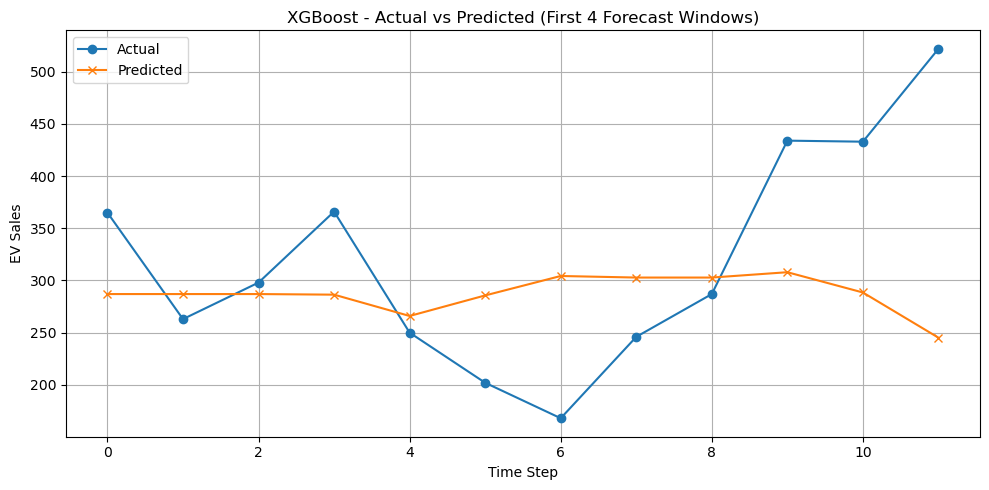

In [28]:
import matplotlib.pyplot as plt

# Filter XGBoost predictions
xgb_results = [r for r in results_limited if r['Model'] == 'XGBoost']

# Reload the dataset to extract true values again
y = df_lagged['Totaal_verkochte_wegvoertuigen'].values

# Extract actuals and predictions for plotting
forecast_horizon = 3
initial_train_size = 12
step_size = 3
actuals = []
predictions = []

# Use all features for plotting
X = df_lagged[all_features].values

for w, i in enumerate(range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size)):
    if w >= 4:  # limit to 4 windows
        break

    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i + forecast_horizon]
    y_test = y[i:i + forecast_horizon]

    model = XGBRegressor(n_estimators=100, verbosity=0, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    actuals.extend(y_test)
    predictions.extend(y_pred)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(actuals, label='Actual', marker='o')
plt.plot(predictions, label='Predicted', marker='x')
plt.title('XGBoost - Actual vs Predicted (First 4 Forecast Windows)')
plt.xlabel('Time Step')
plt.ylabel('EV Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


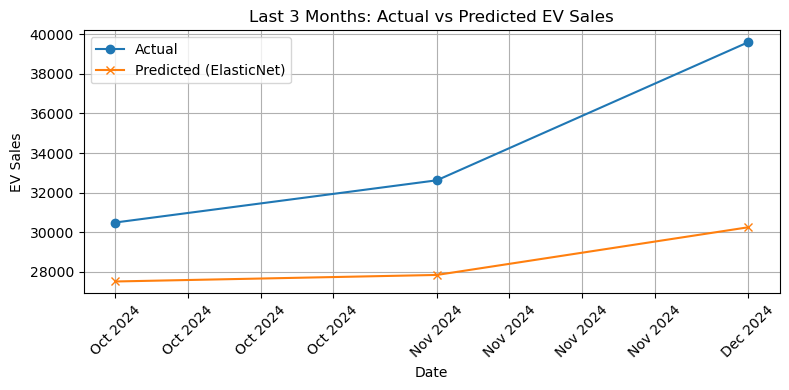

In [32]:
# Filter the timeline to only show the last 3 months of predictions
import matplotlib.dates as mdates

# Convert to DataFrame for easier slicing
timeline_df = pd.DataFrame({
    'Date': timeline_indices,
    'Actual': timeline_actuals,
    'Predicted': timeline_predictions
})

# Sort by date and keep the last 3 months
last_3_months = timeline_df.sort_values('Date').tail(3)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(last_3_months['Date'], last_3_months['Actual'], label='Actual', marker='o')
plt.plot(last_3_months['Date'], last_3_months['Predicted'], label='Predicted (ElasticNet)', marker='x')
plt.title('Last 3 Months: Actual vs Predicted EV Sales')
plt.xlabel('Date')
plt.ylabel('EV Sales')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


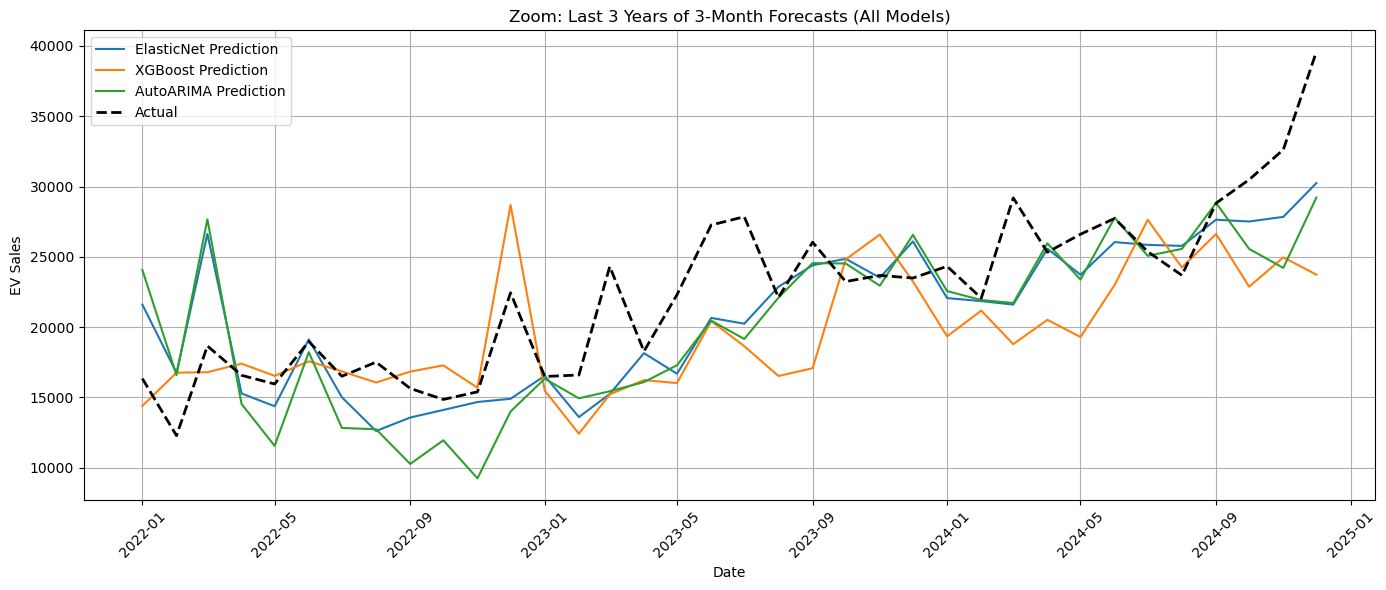

In [36]:
# from sklearn.linear_model import ElasticNet
# from xgboost import XGBRegressor
# from pmdarima import auto_arima
# import matplotlib.pyplot as plt

# Prepare containers for each model
model_outputs = {}

# Define models to evaluate
models = {
    'ElasticNet': lambda: ElasticNet(),
    'XGBoost': lambda: XGBRegressor(n_estimators=50, verbosity=0, random_state=42),
    'AutoARIMA': lambda: None  # Special handling
}

X = df_lagged[all_features].values
y = df_lagged[target_col].values
dates = pd.to_datetime(df_lagged['Periode'])

# Walk-forward setup
for model_name, model_init in models.items():
    preds, actuals, time_stamps = [], [], []

    for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + forecast_horizon], y[i:i + forecast_horizon]
        date_test = dates[i:i + forecast_horizon]

        if model_name == 'AutoARIMA':
            model = auto_arima(y_train, X=X_train, seasonal=False, suppress_warnings=True, stepwise=True, error_action='ignore')
            y_pred = model.predict(n_periods=forecast_horizon, X=X_test)
        else:
            model = model_init()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        preds.extend(y_pred)
        actuals.extend(y_test)
        time_stamps.extend(date_test)

    model_outputs[model_name] = pd.DataFrame({
        'Date': time_stamps,
        'Actual': actuals,
        'Predicted': preds
    })

# Plot all models for the last 3 years
cutoff_date = dates.max() - pd.DateOffset(years=3)
plt.figure(figsize=(14, 6))

for model_name, df in model_outputs.items():
    recent = df[df['Date'] >= cutoff_date]
    plt.plot(recent['Date'], recent['Predicted'], label=f'{model_name} Prediction')

# Plot actuals once
plt.plot(recent['Date'], recent['Actual'], label='Actual', color='black', linestyle='--', linewidth=2)

plt.title('Zoom: Last 3 Years of 3-Month Forecasts (All Models)')
plt.xlabel('Date')
plt.ylabel('EV Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


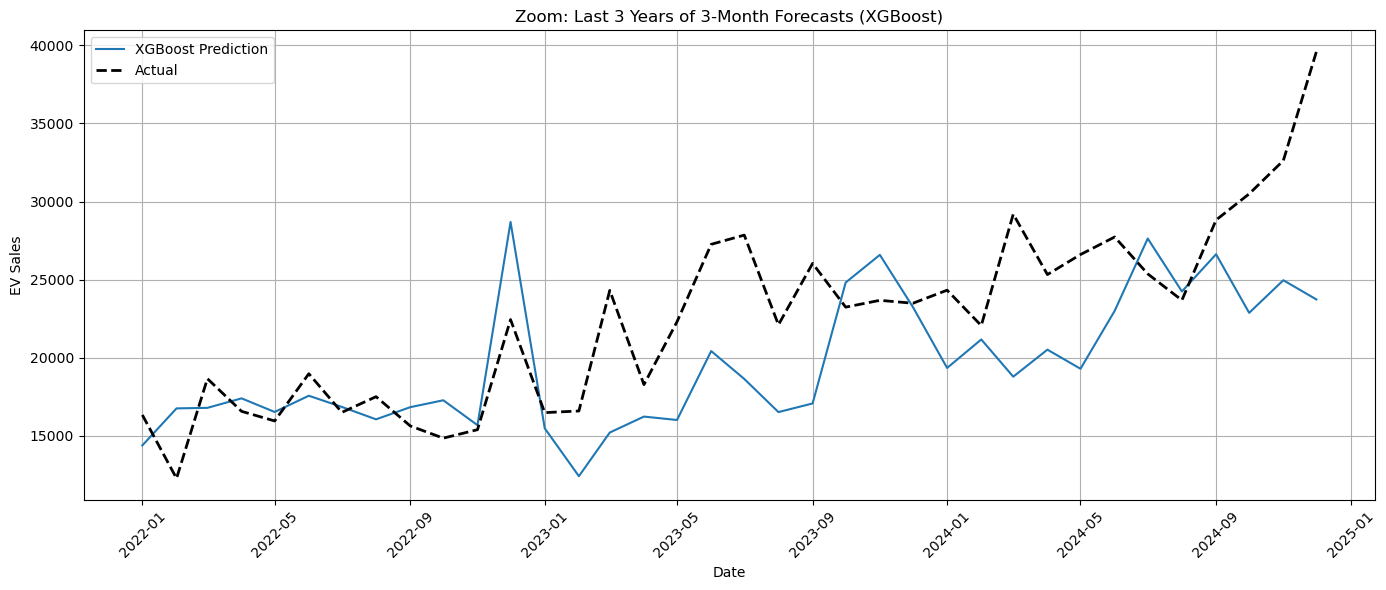

In [38]:
# Plot only XGBoost predicted vs actual for the last 3 years

xgb_df = model_outputs['XGBoost']
cutoff_date = dates.max() - pd.DateOffset(years=3)
recent = xgb_df[xgb_df['Date'] >= cutoff_date]

plt.figure(figsize=(14, 6))
plt.plot(recent['Date'], recent['Predicted'], label='XGBoost Prediction')
plt.plot(recent['Date'], recent['Actual'], label='Actual', color='black', linestyle='--', linewidth=2)
plt.title('Zoom: Last 3 Years of 3-Month Forecasts (XGBoost)')
plt.xlabel('Date')
plt.ylabel('EV Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


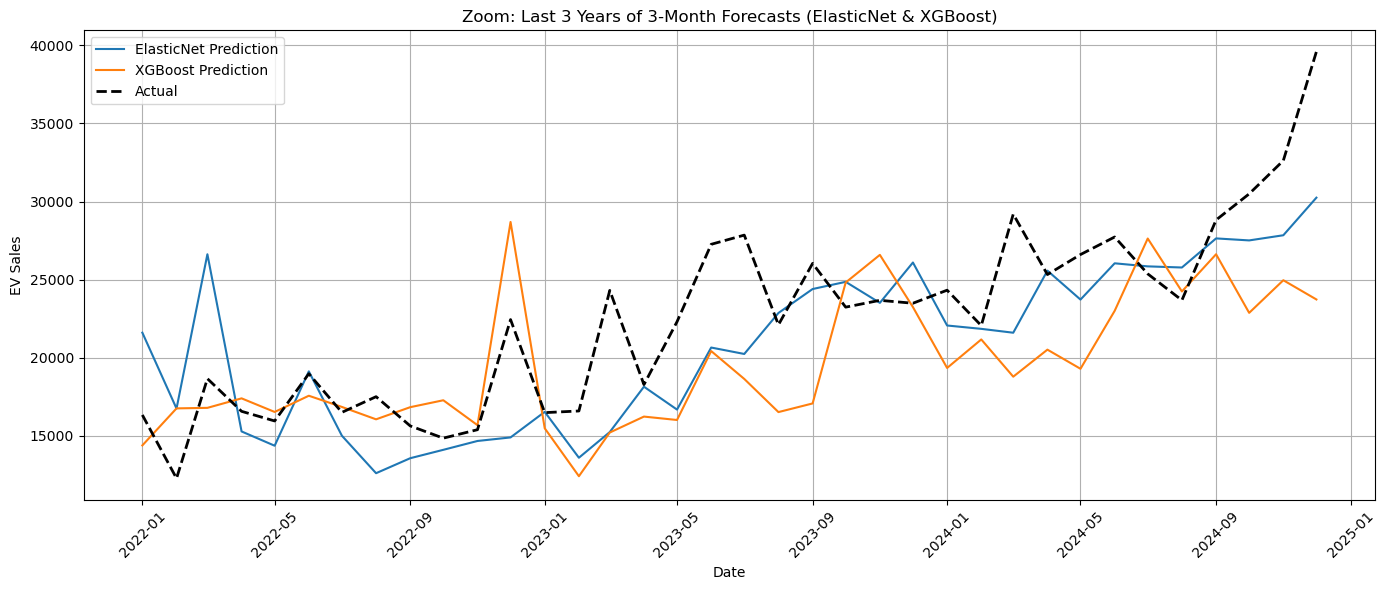

In [34]:
# Re-run only for ElasticNet and XGBoost to avoid the pmdarima error

# Define simplified models (ElasticNet and XGBoost only)
models_simple = {
    'ElasticNet': lambda: ElasticNet(),
    'XGBoost': lambda: XGBRegressor(n_estimators=50, verbosity=0, random_state=42)
}

# Clear container
model_outputs_simple = {}

# Re-run walk-forward
for model_name, model_init in models_simple.items():
    preds, actuals, time_stamps = [], [], []

    for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1, step_size):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + forecast_horizon], y[i:i + forecast_horizon]
        date_test = dates[i:i + forecast_horizon]

        model = model_init()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        preds.extend(y_pred)
        actuals.extend(y_test)
        time_stamps.extend(date_test)

    model_outputs_simple[model_name] = pd.DataFrame({
        'Date': time_stamps,
        'Actual': actuals,
        'Predicted': preds
    })

# Plot for last 3 years
cutoff_date = dates.max() - pd.DateOffset(years=3)
plt.figure(figsize=(14, 6))

for model_name, df in model_outputs_simple.items():
    recent = df[df['Date'] >= cutoff_date]
    plt.plot(recent['Date'], recent['Predicted'], label=f'{model_name} Prediction')

# Plot actuals once
plt.plot(recent['Date'], recent['Actual'], label='Actual', color='black', linestyle='--', linewidth=2)

plt.title('Zoom: Last 3 Years of 3-Month Forecasts (ElasticNet & XGBoost)')
plt.xlabel('Date')
plt.ylabel('EV Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
